

---



* 작성자: 한양대ERICA, 산업경영공학과, 김윤성
* 마지막 수정일: 2023.04.26


---



- 돌릴때 하드웨어 가속기 GPU로 바꿀것
- 하루에 코랩 GPU할당량이 다 되면 커널이 죽을 수 있음

# (1) Preliminaries

In [ ]:
# 데이터 전처리 패키지
import numpy as np
import pandas as pd

# 데이터 시각화 패키지
import matplotlib.pyplot as plt   

# 머신러닝 패키지
import tensorflow as tf 
from keras import layers   

# (2) Load the dataset 

In [ ]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
print ("Training data:")
print ("Number of examples: ", X_train.shape[0])
print ("Number of channels:",X_train.shape[3]) 
print ("Image size:", X_train.shape[1], X_train.shape[2])
print
print ("Test data:")
print ("Number of examples:", X_test.shape[0])
print ("Number of channels:", X_test.shape[3])
print ("Image size:", X_test.shape[1], X_test.shape[2]) 

Training data:
Number of examples:  50000
Number of channels: 3
Image size: 32 32
Test data:
Number of examples: 10000
Number of channels: 3
Image size: 32 32


In [ ]:
# 데이터 전처리: 0에서 255 사이의 값을 갖는 훈련/테스트 데이터들을 0.0~1.0 사이의 값을 갖도록 변환
# min-max scaler임
X_train = X_train / 255.0
X_test = X_test / 255.0

# (3) Build the model

In [ ]:
# 모델 정의
model = tf.keras.models.Sequential([
  # input_shape -> 28*28 이미지임
  # Flatten으로 1차원으로 펴줌 -> 노드에 집어넣기 편한 형태로 변환해주는 작업임
  tf.keras.layers.Flatten(input_shape=(32,32,3)),
  # 히든레이어 첫번째의 노드 갯수 1024개
  tf.keras.layers.Dense(units = 1024, activation='relu'),  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.25),
  # 히든레이어 첫번째의 노드 갯수 512개
  tf.keras.layers.Dense(units = 512, activation='relu'),  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.25),
  # 히든레이어 두번째의 노드 갯수 256개
  tf.keras.layers.Dense(units = 256, activation='relu'), 
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.Dense(units = 128, activation='relu'),  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.25),
  # 히든레이어 두번째의 노드 갯수 256개
  tf.keras.layers.Dense(units = 256, activation='relu'), 
  tf.keras.layers.BatchNormalization(), 
  # 히든레이어 세번째의 노드 갯수 128개
  tf.keras.layers.Dense(units = 128, activation='relu'),  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.25),
  # 히든레이어 네번째의 노드 갯수 64개
  tf.keras.layers.Dense(units = 64, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  # 오버피팅 잡아줌
  # Dropout 위치는 사용자가 오버피팅을 최대한 잡아주는 구간을 결정해서 넣음
  # 50% 확률로 랜덤하게 노드에 갈지말지 결정함
  tf.keras.layers.Dropout(0.5),
  # 히든레이어 다섯번째 노드수 32개
  tf.keras.layers.Dense(units = 32, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  # Output 레이어를 클래스의 개수가 10개이므로 10으로 잡음
  # softmax함수로 다중 분류를 해줌
  tf.keras.layers.Dense(units = 10, activation='softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_32 (Dense)            (None, 1024)              3146752   
                                                                 
 batch_normalization_27 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_33 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_28 (Bat  (None, 512)              2048      
 chNormalization)                                     

In [ ]:
# 최적화 함수 정의하기
model.compile(optimizer='adam',  
              loss='sparse_categorical_crossentropy', 
              # 평가기준을 정확도도 넣음
              metrics=['accuracy'])  

# (4) Training

In [ ]:
%%time
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)


# 하이퍼 파라미터를 튜닝해서 돌려볼 것
# 100 epoch에 대한 훈련을 실행하고 진행 과정 기록
history = model.fit(X_train, y_train, 
                    epochs = 90, 
                    # 데이터가 크기 때문에 batch_size를 설정하여 데이터를 묶어서 보고 y값을 업데이트를 함
                    # batch size를 크게하면 학습이 제대로 안될 수도 있음, 작게하면 학습 속도가 아주 낮음
                    batch_size=110,
                    validation_split=0.3,
                    callbacks=[early_stop])

Epoch 1/90
319/319 [==============================] - 5s 15ms/step - loss: 1.3517 - accuracy: 0.5288 - val_loss: 1.4240 - val_accuracy: 0.4968
Epoch 2/90
319/319 [==============================] - 4s 12ms/step - loss: 1.3474 - accuracy: 0.5289 - val_loss: 1.3988 - val_accuracy: 0.5066
Epoch 3/90
319/319 [==============================] - 4s 14ms/step - loss: 1.3504 - accuracy: 0.5280 - val_loss: 1.4249 - val_accuracy: 0.5031
Epoch 4/90
319/319 [==============================] - 4s 11ms/step - loss: 1.3417 - accuracy: 0.5340 - val_loss: 1.4034 - val_accuracy: 0.5102
Epoch 5/90
319/319 [==============================] - 4s 12ms/step - loss: 1.3375 - accuracy: 0.5341 - val_loss: 1.5301 - val_accuracy: 0.4679
Epoch 6/90
319/319 [==============================] - 5s 16ms/step - loss: 1.3298 - accuracy: 0.5363 - val_loss: 1.4164 - val_accuracy: 0.5050
Epoch 7/90
319/319 [==============================] - 4s 12ms/step - loss: 1.3263 - accuracy: 0.5369 - val_loss: 1.4210 - val_accuracy: 0.4989

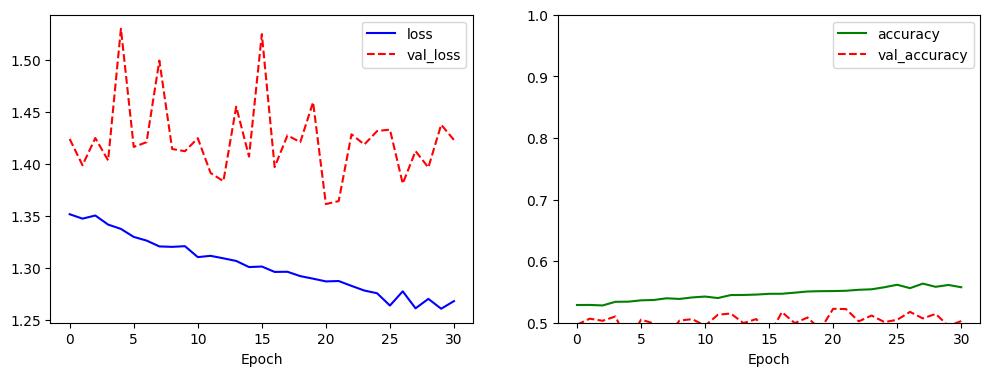

In [ ]:
# 훈련과정 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
# loss는 수치이므로 1을 넘어갈 수 있음 -> 확률이랑 착각 ㄴㄴ
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy 그래프
# 확률 값임
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.5, 1)
plt.legend()

plt.show()

# (5) Evaluation

In [ ]:
# 테스트 결과 확인 
loss, accuracy = model.evaluate(X_test, y_test)
print('loss : ', loss)
print('accuracy : ', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 1.3454 - accuracy: 0.5328
loss :  1.345409870147705
accuracy :  0.532800018787384


In [ ]:
# 모델 예측
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 3ms/step - loss: 1.3454 - accuracy: 0.5328
Accuracy: 0.532800018787384
              precision    recall  f1-score   support

           0       0.59      0.58      0.58      1000
           1       0.62      0.62      0.62      1000
           2       0.45      0.36      0.40      1000
           3       0.35      0.45      0.39      1000
           4       0.45      0.51      0.48      1000
           5       0.58      0.28      0.38      1000
           6       0.53      0.63      0.58      1000
           7       0.68      0.52      0.59      1000
           8       0.62      0.71      0.66      1000
           9       0.55      0.66      0.60      1000

    accuracy                           0.53     10000
   macro avg       0.54      0.53      0.53     10000
weighted avg       0.54      0.53      0.53     10000



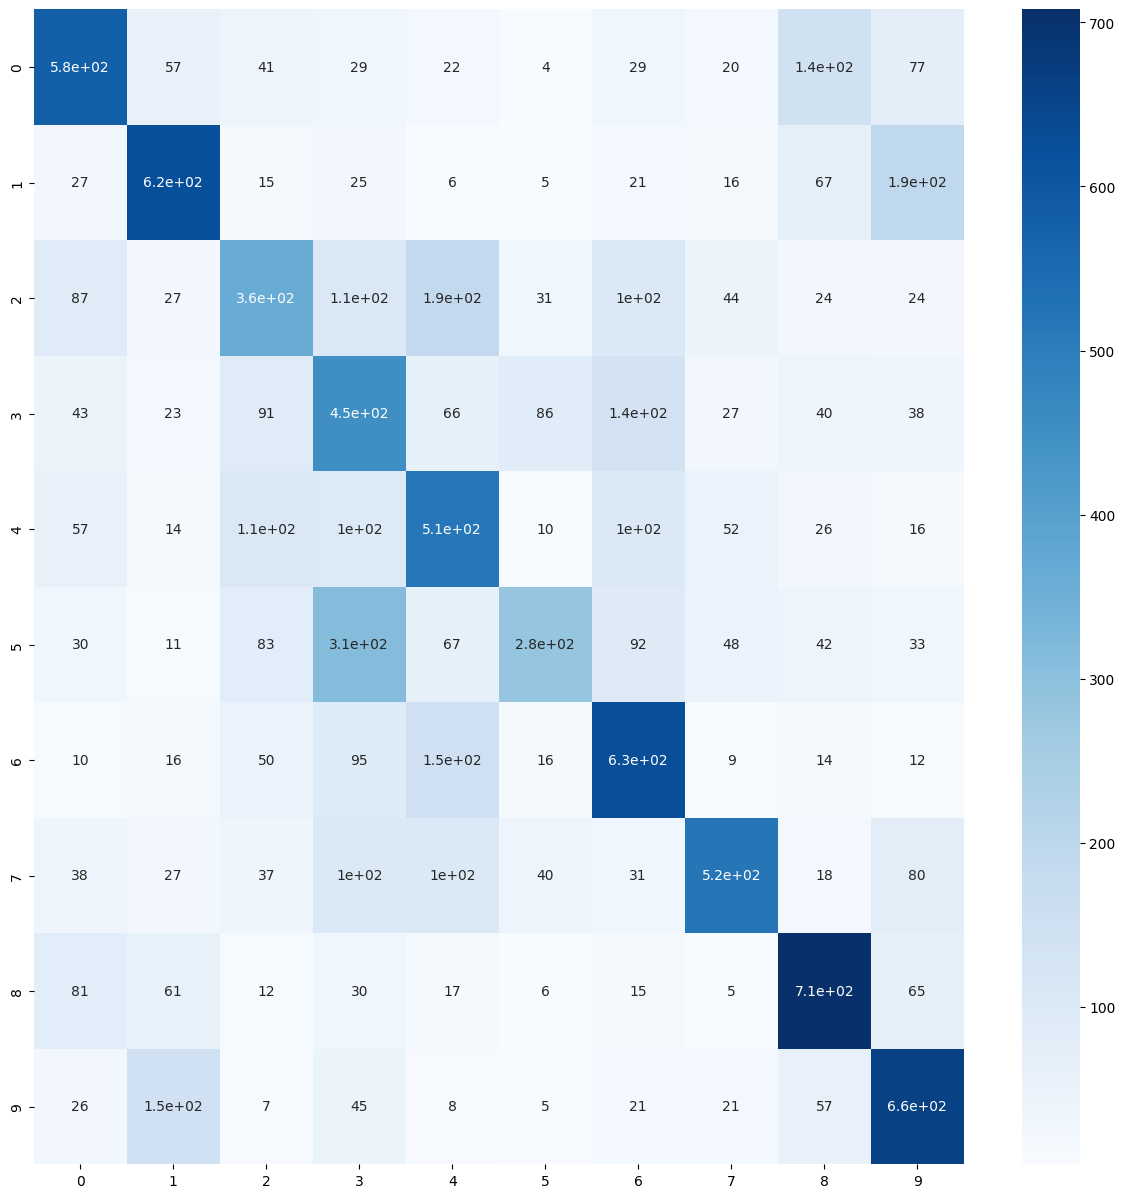

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))


plt.figure(figsize=(15, 15))
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()